# Portfolio exercises:
### 1. load and inspect the data 
- what are missing/problematic entries?

### 2. data exploration and cleaning 
- remove, fill, change data (if you think this makes sense or is necessary/beneficial)
- inspect two different types of labels (`label` and `infection_type`). How many classes are there and is there any bias? If so, is there anything we have to take care of?


### 3. Prepare data for machine learning: 
- Separate data / labels
- Split into train ~70% / validation ~15% / test ~15%

### 4. Build an image generator pipeline
- Use keras `ImageDataGenerator` to define a `train_generator` and a `validation_generator`.
- Use the generator to recale the pixel values and to reshape the image to the desired format.

### 5. Train your own custom-made CNN (pneumonia yes/no prediction)
- Define a conventional CNN image classifier (convolution-pooling steps, followed by dense layers) to predict if a patient has pneumonia or not.

### 6. Use transfer learning to train a CNN classifier (pneumonia yes/no prediction)
- Pick any suitable CNN you like (e.g. Resnet-50, Densenet, MobileNet...) and create your own image classifier from there.

### 7. Evaluate both models
- Evaluate the models on data other than the training data.
- Plot a ROC curve and compute the area under the curve (AUC). What does this tell you?
- Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

### 8. Train a CNN for a multi-class prediction (bacteria, virus, none)
- Adapt a CNN (e.g. pick one form 5. or 6.) and modify it to predict if a patient has a bacterial or a virus infection, or none of both using the `infection_type` column as label.
- This requires to also adapt the generators.

### 9. Evaluate the multi-class model
- Evaluate the multi-class prediction model, simliar to what you did in (7.). Again also include a ROC curve (now of course for all 3 possible labels).
- Is the performance comparable, better, worse than the pneumonia/no pneumonia case?
- Which label can be predicted with the highest precision?

### 10. Possible improvements
Try two possible strategies to improve the results you got on 8. and 9.
- Data augmentation.
- Model fine tuning. This refers to the training of a large network with lower learning rate, but with more layers of the base model being set to `trainable`.
We haven't done this before, so here some example code of how to "unfreeze" some layers and make them trainable again:
```python
# Now: unfreeze some of the base model layers and do a second pass of training
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True
``` 
You can still use the `Adam` optimizer, but preferably with a much lower learning rate, maybe `1e-5`.
- Do you see any promising effect of one or both of those strategies?


## Final submission:
Please address all the above mentioned points in this notebook (e.g., using text cells where needed for explanations or answers). Obviously, you can use code snippets from notebooks we have already worked on during the live coding sessions.


### Happy hacking!!!

In [39]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import seaborn as sb


## The Dataset

Similar to former notebooks where we worked with the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315), where here have a smaller X-ray dataset containing 5856 images.
Instead of 14 different diseases we will here concentrate on much fewer possible labels so that *hopefully* the number of images is enough to train good deep learning classifiers.

The images are distributed accross two folders (`NORMAL` and `PNEUMONIA`), the related metadata can be found in `x_ray_metadata_portfolio.csv` but actually also is reflected in the image file names.

## Import metadata

In [2]:
path_data = "data/ChestXray_pneumonia_prediction/"
filename = "x_ray_metadata_portfolio.csv"
metadata = pd.read_csv(os.path.join(path_data,filename))
metadata.head()

,patient_id,label,infection_type,folder,image
0,0001,normal,none,NORMAL,IM-0001-0001.jpeg
1,0003,normal,none,NORMAL,IM-0003-0001.jpeg
2,0005,normal,none,NORMAL,IM-0005-0001.jpeg
3,0006,normal,none,NORMAL,IM-0006-0001.jpeg
4,0007,normal,none,NORMAL,IM-0007-0001.jpeg


### 1. load and inspect the data 


In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      5856 non-null   object
 1   label           5856 non-null   object
 2   infection_type  5856 non-null   object
 3   folder          5856 non-null   object
 4   image           5856 non-null   object
dtypes: object(5)
memory usage: 228.9+ KB


Auf den ersten Blick keine fehlenden Daten. Die Datentypen sind alles Objekte. Die Labels noch in numerische Form gebracht werden.

In [4]:
metadata.describe()

,patient_id,label,infection_type,folder,image
count,5856,5856,5856,5856,5856
unique,2790,2,3,2,5856
top,person23,pneumonia,bacteria,PNEUMONIA,IM-0001-0001.jpeg
freq,31,4273,2780,4273,1


Nur 2790 Patienten haben eine unique ID. Wir haben 5856 unique Bilder, die sich auf 2790 Patienten verteilen. Das heißt, dass es Patienten gibt, die mehrere Bilder im Datenset haben. Das ist problematisch da es zu Data Leakage führen kann. Später muss beim Aufteilen des Datensets darauf geachtet werden, dass die Bilder eines Patienten nicht in Train, Val- und Testset aufgeteilt werden.

In [5]:
metadata["patient_id"]

0           0001
1           0003
2           0005
3           0006
4           0007
          ...   
5851    person99
5852     person9
5853     person9
5854     person9
5855     person9
Name: patient_id, Length: 5856, dtype: object

Die Spalte Patienten ID hat kein konsistentes Format. Es gibt numerische Einträge sowie Einträge mit Buchstaben (Strings). Da die Spalte aber nicht für das Training verwendet wird, ist der Datentyp nicht weiter schlimm. 

In [6]:
metadata["patient_id"].value_counts()

person23      31
person124     20
person441     18
person30      15
person1320    14
              ..
person1580     1
0907           1
person1579     1
person1577     1
0001           1
Name: patient_id, Length: 2790, dtype: int64

Wie vermutet gibt es Patienten mit mehreren Bildern im Datenset.

In [7]:
mask = metadata["patient_id"] == "person23"
metadata[mask]

,patient_id,label,infection_type,folder,image
3494,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_100.jpeg
3495,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_101.jpeg
3496,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_102.jpeg
3497,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_103.jpeg
3498,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_104.jpeg
3499,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_105.jpeg
3500,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_106.jpeg
3501,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_107.jpeg
3502,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_78.jpeg
3503,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_79.jpeg


Es gibt Patienten die oft in den Daten auftauchen und die anscheindend sowohl eine bakterielle als auch eine virale Infektion hatten.

#### What are missing/problematic entries?
Wie oben beschrieben gibt es keine fehlende Daten. Allerdings müssen die Labels noch in numerische Form gebracht werden, das liegt aktuell noch nicht vor.  Außerdem gibt es Patienten mit mehreren Bildern im Datenset. Das kann zu Data Leakage führen. Beim Aufteilen des Datensets muss darauf geachtet werden, dass die Bilder eines Patienten nicht in Train, Val- und Testset aufgeteilt werden. Später muss beim Laden der Bilder auch auf den Ordner geachtet werden. Aktuell gibt es zwei Spalten mit folder und image. Diese könnten im Data Cleaning zusammengeführt werden.


### 2. data exploration and cleaning 

In [8]:
metadata["label"]

0          normal
1          normal
2          normal
3          normal
4          normal
          ...    
5851    pneumonia
5852    pneumonia
5853    pneumonia
5854    pneumonia
5855    pneumonia
Name: label, Length: 5856, dtype: object

Das Label liegt aktuell als String vor. Es muss noch in eine numerische Form gebracht werden, entweder mit Label Encoding oder One-Hot-Encoding.

In [9]:
metadata["label"].value_counts()

pneumonia    4273
normal       1583
Name: label, dtype: int64

Das Label `label` besitzt 2 Klassen. Entweder hat man Pneumonie oder nicht (normal). Es liegt ein Bias vor, da wir deutlich mehr Bilder von Patienten mit einer Pneumonie haben als von Patienten ohne Pneumonie.

In [10]:
metadata["infection_type"].value_counts()

bacteria    2780
none        1583
virus       1493
Name: infection_type, dtype: int64

Das Label `infection_type` besteht aus 3 Klassen. Entweder hat ein Patient keine Infektion oder eine bakterielle oder eine virale Infektion.
Auch hier liegt ein Bias vor, da es ca. doppelt so viele Bakterien- wie Viren-Infektionen/keine Infektionen gibt. Auch hier muss das Label noch in eine numerische Form gebracht werden. Im späteren Verlauf werde ich Class Weights berechnen und anwenden, um den Bias im Label auszugleichen.

In [11]:
mask = metadata["label"] == "normal"
metadata[mask]["infection_type"].value_counts()

none    1583
Name: infection_type, dtype: int64

Alle Patienten mit dem Label "normal" haben beim Infektionstyp "none" stehen. In der Hinsicht sind 
die Daten also konsistent.

#### Label Encoding/One-Hot-Encoding

In [12]:
metadata

,patient_id,label,infection_type,folder,image
0,0001,normal,none,NORMAL,IM-0001-0001.jpeg
1,0003,normal,none,NORMAL,IM-0003-0001.jpeg
2,0005,normal,none,NORMAL,IM-0005-0001.jpeg
3,0006,normal,none,NORMAL,IM-0006-0001.jpeg
4,0007,normal,none,NORMAL,IM-0007-0001.jpeg
...,...,...,...,...,...
5851,person99,pneumonia,virus,PNEUMONIA,person99_virus_183.jpeg
5852,person9,pneumonia,bacteria,PNEUMONIA,person9_bacteria_38.jpeg
5853,person9,pneumonia,bacteria,PNEUMONIA,person9_bacteria_39.jpeg
5854,person9,pneumonia,bacteria,PNEUMONIA,person9_bacteria_40.jpeg


In [13]:
from sklearn.preprocessing import LabelEncoder

metadata["label"] = LabelEncoder().fit_transform(metadata["label"])

Für das Label `label` verwende den Label Encoder von sklearn, der die Werte binär in Null und Eins umwandelt.

In [14]:
labels_for_infection_type = pd.get_dummies(metadata["infection_type"])
labels_for_infection_type


,bacteria,none,virus
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
5851,0,0,1
5852,1,0,0
5853,1,0,0
5854,1,0,0


Für das zweite Label `infection type` erstelle ich mit pandas ein One-Hot-Encoding. Da es 3 Klassen gibt, werden 3 Spalten erstellt und an das Metadata Dataframe angehängt. 

In [15]:
#add the new columns to the metadata dataframe
metadata = pd.concat([metadata,labels_for_infection_type],axis=1)
metadata

,patient_id,label,infection_type,folder,image,bacteria,none,virus
0,0001,0,none,NORMAL,IM-0001-0001.jpeg,0,1,0
1,0003,0,none,NORMAL,IM-0003-0001.jpeg,0,1,0
2,0005,0,none,NORMAL,IM-0005-0001.jpeg,0,1,0
3,0006,0,none,NORMAL,IM-0006-0001.jpeg,0,1,0
4,0007,0,none,NORMAL,IM-0007-0001.jpeg,0,1,0
...,...,...,...,...,...,...,...,...
5851,person99,1,virus,PNEUMONIA,person99_virus_183.jpeg,0,0,1
5852,person9,1,bacteria,PNEUMONIA,person9_bacteria_38.jpeg,1,0,0
5853,person9,1,bacteria,PNEUMONIA,person9_bacteria_39.jpeg,1,0,0
5854,person9,1,bacteria,PNEUMONIA,person9_bacteria_40.jpeg,1,0,0


Die Labels liegen nun in numerischer Form vor und können zum Training verwendet werden. Ansich ist das Label `infection_type` nicht mehr notwendig und könnte gelöscht werden. Da es aber keinen großen Performance Unterschied macht, lasse ich es im Dataframe. Das Label `label` benenne ich der Übersicht halber in `pneumonia` um.

In [16]:
#rename label column to pneumonia
metadata = metadata.rename(columns={"label":"pneumonia"})
metadata.head()

,patient_id,pneumonia,infection_type,folder,image,bacteria,none,virus
0,0001,0,none,NORMAL,IM-0001-0001.jpeg,0,1,0
1,0003,0,none,NORMAL,IM-0003-0001.jpeg,0,1,0
2,0005,0,none,NORMAL,IM-0005-0001.jpeg,0,1,0
3,0006,0,none,NORMAL,IM-0006-0001.jpeg,0,1,0
4,0007,0,none,NORMAL,IM-0007-0001.jpeg,0,1,0


In [17]:
path_images = "data/ChestXray_pneumonia_prediction/"
metadata["image_path_and_filename"] = path_images + metadata["folder"] + "/" + metadata["image"]
metadata

,patient_id,pneumonia,infection_type,folder,image,bacteria,none,virus,image_path_and_filename
0,0001,0,none,NORMAL,IM-0001-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
1,0003,0,none,NORMAL,IM-0003-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
2,0005,0,none,NORMAL,IM-0005-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
3,0006,0,none,NORMAL,IM-0006-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
4,0007,0,none,NORMAL,IM-0007-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
...,...,...,...,...,...,...,...,...,...
5851,person99,1,virus,PNEUMONIA,person99_virus_183.jpeg,0,0,1,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5852,person9,1,bacteria,PNEUMONIA,person9_bacteria_38.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5853,person9,1,bacteria,PNEUMONIA,person9_bacteria_39.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5854,person9,1,bacteria,PNEUMONIA,person9_bacteria_40.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...


Um später den Keras Image Generator zu verwenden, erstelle ich eine neue Spalte in der der komplette Pfad plus Dateiname des Bildes steht. Das ist nötig, da sich der Dateipfad der Bilder abhängig von der Folder Spalte ändert. Man könnte die Bilder auch in einen Ordner kopieren, aber ich möchte die ursprüngliche Ordnerstruktur nicht verändern. Auch hier könnte man die Spalten `folder` und `image` löschen. Ich lasse sie zur Kontrolle aber im Dataframe.

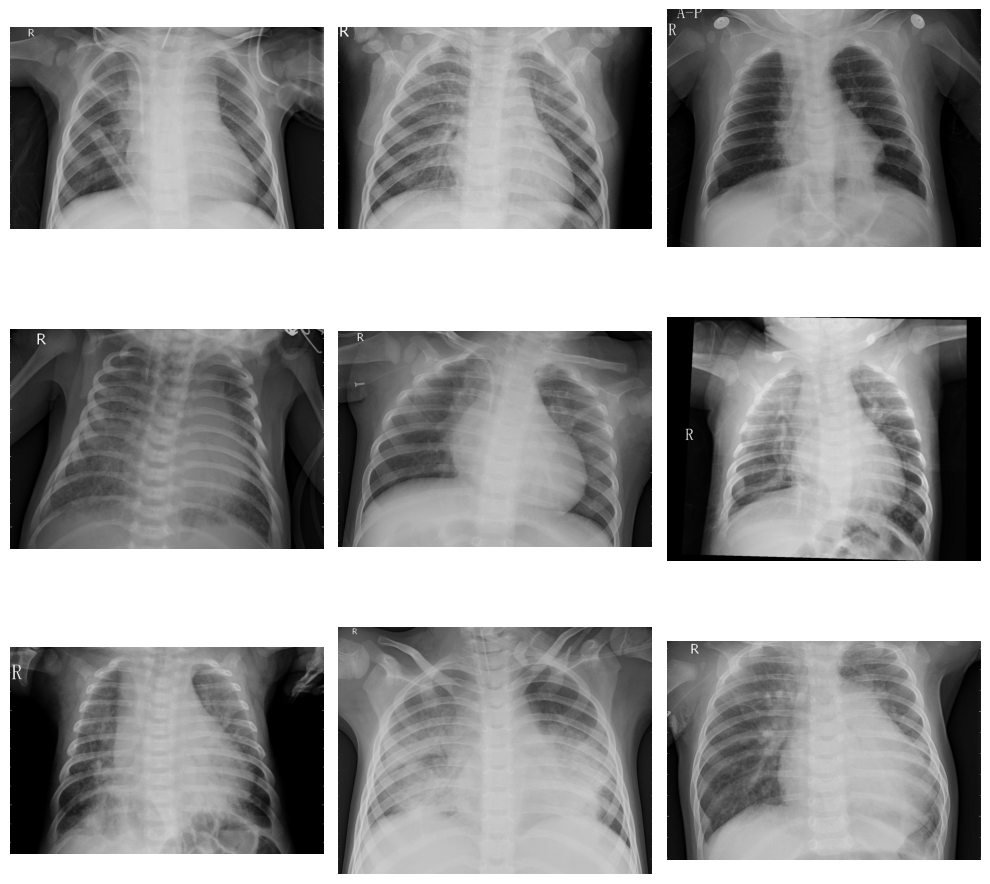

In [18]:
path_images = "data/ChestXray_pneumonia_prediction/PNEUMONIA/"

# Pick 9 random images
np.random.seed(1)
mask = metadata["folder"] == "PNEUMONIA"
random_images = np.random.choice(metadata[mask]["image"], 9)


# Adjust the size of your images
plt.figure(figsize=(10,10))

# Iterate and plot random images
for i, filename in enumerate(random_images):
    filename = filename
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(path_images, filename))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

Die Bilder liegen in Graustufen vor.

#### Inspect two different types of labels (`label` and `infection_type`). How many classes are there and is there any bias? If so, is there anything we have to take care of? 
Wie oben beschrieben hat das `label` zwei Klassen: Pneumonia oder Normal. Das Label `infection_type` hat 3 Klassen: Bakterielle Infektion, Virale Infektion oder keine Infektion. Beide Labels haben einen Bias. Es gibt deutlich mehr Bilder von Patienten mit einer Pneumonie als von Patienten ohne Pneumonie. Auch gibt es mehr Bakterien- als Viren-Infektionen oder keine Infektionen. Das muss beim Training berücksichtigt werden, damit das Modell nicht nur auf die häufigste Klasse trainiert wird. Methoden dafür wären Class Weights oder Oversampling.

### 3. Prepare data for machine learning: 
- Separate data / labels
- Split into train ~70% / validation ~15% / test ~15%

In [19]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(metadata, test_size=0.2, random_state=42)

In [20]:
train_data

,patient_id,pneumonia,infection_type,folder,image,bacteria,none,virus,image_path_and_filename
4620,person503,1,bacteria,PNEUMONIA,person503_bacteria_2125.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
3274,person1700,1,bacteria,PNEUMONIA,person1700_bacteria_4502.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5724,person939,1,bacteria,PNEUMONIA,person939_bacteria_2864.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
3390,person1866,1,bacteria,PNEUMONIA,person1866_bacteria_4740.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
113,0203,0,none,NORMAL,IM-0203-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
...,...,...,...,...,...,...,...,...,...
3772,person301,1,bacteria,PNEUMONIA,person301_bacteria_1428.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5191,person66,1,bacteria,PNEUMONIA,person66_bacteria_325.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5226,person688,1,bacteria,PNEUMONIA,person688_bacteria_2584.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5390,person766,1,bacteria,PNEUMONIA,person766_bacteria_2670.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...


In [21]:
from sklearn.model_selection import train_test_split

patient_ids = metadata['patient_id'].unique()
train_ids, test_ids = train_test_split(patient_ids, test_size=0.15, random_state=42)
train_data = metadata[metadata['patient_id'].isin(train_ids)]
test_data = metadata[metadata['patient_id'].isin(test_ids)]

train_ids, val_ids = train_test_split(train_ids, test_size=0.178, random_state=42)
train_data = metadata[metadata['patient_id'].isin(train_ids)]
val_data = metadata[metadata['patient_id'].isin(val_ids)]

print(f"Training set size: {train_data.shape}")
print(f"Validation set size: {val_data.shape}")
print(f"Test set size: {test_data.shape}")

Training set size: (4102, 9)
Validation set size: (878, 9)
Test set size: (876, 9)


Um Data Leakage zu vermeiden, werden die Daten nach uniquen Patienten IDs aufgeteilt. Diese werden anschließend aufgeteilt in train und test ids. Anhand dieser lassen sich die Train- und Testdaten aus den Metadaten auslesen, sodass nur einzigartige IDs in den entsprechenden Splits sind. Der Vorgang wird bei dem Val-Datenset wiederholt. Das Resultat ist, dass die Bilder eines Patienten nicht in Train, Val- und Testset aufgeteilt werden. 

In [22]:
for patient_id in train_data['patient_id']:
    assert patient_id not in val_data['patient_id'] # throw an error if patient_id is in val_data
    assert patient_id not in test_data['patient_id'] # throw an error if patient_id is in test_data

Hier wird überprüft ob mein train_test_split funktioniert hat. Es wird überprüft, ob die Patienten IDs in den Splits nicht doppelt vorkommen. Sollte das der Fall sein wird ein Fehler geworfen.

In [23]:
classes = ["none", "bacteria", "virus"]

Festlegung der Klassen für das zweite Label.

In [24]:
print(train_data['pneumonia'].value_counts())
print(train_data[classes].sum().sort_values(ascending=False))

1    3030
0    1072
Name: pneumonia, dtype: int64
bacteria    1990
none        1072
virus       1040
dtype: int64


In [25]:
print(test_data['pneumonia'].value_counts())
print(test_data[classes].sum().sort_values(ascending=False))

1    613
0    263
Name: pneumonia, dtype: int64
bacteria    386
none        263
virus       227
dtype: int64


In [26]:
print(val_data['pneumonia'].value_counts())
print(val_data[classes].sum().sort_values(ascending=False))

1    630
0    248
Name: pneumonia, dtype: int64
bacteria    404
none        248
virus       226
dtype: int64


Der Bias hat sich durch das Aufteilen der Daten nicht stark verändert. Im Trainingsset haben wir fast 3 mal so viele Pneumonie-Bilder (1) wie normale Bilder (0). Im Testset und Valset haben wir ca. 2.5 mal so viele Pneumonie-Bilder wie normale Bilder. Bei dem Multi Class Label (`Bacteria, None, Virus`) liegt ebenfalls ein leichter Bias vor. Tendenziell gibt es von Bacteria fast doppelt so viele Datenpunkte als von den anderen zwei Klassen. Ich werde vor dem jeweiligen Training des Models Class Weights für den Trainingsdatensatz berechnen, um den Bias auszugleichen.

### 4. Build an image generator pipeline
- Use keras `ImageDataGenerator` to define a `train_generator` and a `validation_generator`.
- Use the generator to recale the pixel values and to reshape the image to the desired format.

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255 #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
)

# select the column with the labels
label_column = "pneumonia"

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
        dataframe=train_data,
        x_col="image_path_and_filename", #x_col is the column with the filenames
        y_col=label_column,
        target_size=(320,320),
        batch_size=32, #how many images are loaded at once. 
        class_mode="raw", #raw because we have only one label column which is already encoded in 0 and 1
        color_mode="grayscale" #grayscale because we have grayscale images
)
val_generator = image_generator.flow_from_dataframe(
        dataframe=val_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="grayscale",
        shuffle = False) #im val dataset wollen wir nicht das er shuffelt sonst haben wir eine unterschiedliche Reihenfolge wenn wir auf val predicten

Found 4102 validated image filenames.
Found 878 validated image filenames.


Es wurden 2 Image Generatoren mit Keras erstellt, die die Bilder aus den jeweiligen Ordnern laden. Die Bilder werden in Graustufen geladen und auf eine Größe von 320x320 Pixeln skaliert. Die Pixelwerte werden auf einen Wertebereich von 0 bis 1 skaliert. Als Label wurde die Spalte `pneumonia` verwendet, sodass das Model später vorhersagen kann, ob man Pneumonia hat (1) oder nicht (0). Der Shuffle im Validation Generator wurde ausgestellt, um die Reihenfolge der Bilder beizubehalten und so später leichter die Labels mit der Vorhersage vergleichen zu können.

#### Inspect the generators

In [28]:
batch = next(train_generator)

In [29]:
batch[1] #labels

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Die Labels liegen wie erwartet binär vor.

In [30]:
batch[0].shape

(32, 320, 320, 1)

Wir haben eine Batch Size von 32 Bildern die auf einmal dem Model zum Trainieren übergeben werden. Jedes Bild ist 320x320 px groß und hat 1 Farbkanal (Graustufen).

In [31]:
first_image = batch[0][0]
first_image.min(), first_image.max()

(0.0, 1.0)

Die Bilder haben Pixelwerte zwischen 0 und 1.

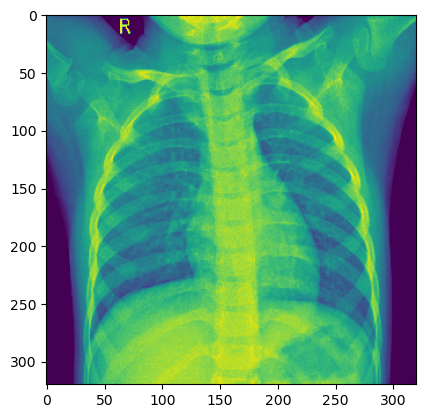

In [32]:
plt.imshow(first_image)

Man sieht gut, dass die Größe auf 320x320 Pixel skaliert wurde. Durch die Cmap von matplotlib werden die Bilder in Farbe angezeigt, es liegt allerdings in Graustufen mit einem Farbkanal vor, wie man bei dem shape (32, 320, 320, 1) gut erkennen kann.

### 5. Train your own custom-made CNN (pneumonia yes/no prediction)
- Define a conventional CNN image classifier (convolution-pooling steps, followed by dense layers) to predict if a patient has pneumonia or not.

In [33]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Model

In [34]:
inputs = Input(shape=(320,320,1)) # 320x320 pixel, 1 channel (grayscale)

# Define CNN architecture
x = Conv2D(32, (3, 3))(inputs) # 32 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x) # 2x2 max pooling, halbiert die Breite und Höhe des Bildes    
x = Conv2D(64, (3, 3))(x) # 64 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x) 
x = Conv2D(128, (3, 3))(x) # 128 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3))(x) # man erhöht die Anzahl der Filter damit man auch komplexere Muster erkennen kann. Kleinere Filter erkennen eher simple Muster (z.B. Verstärunkung vertikaler Konturen) 
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x) # Umwandlung in einen Vektor 
x = Dense(64, activation = "relu")(x) # 64 Neuronen im hidden layer mit Relu als Aktivierungsfunktion -> Negative Werte werden auf 0 gesetzt
outputs = Dense(1, activation = "sigmoid")(x) # sigmoid weil wir nur 2 Klassen haben -> Wert zwischen 0 und 1

# Create model
model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 159, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 128)       73856 

Ich habe mich für ein recht einfach aufgebautes CNN aus dem Live Coding entschieden. Dieses hat 5 Conv-Pooling Blöcke und der letzte Dense Layer besteht aus einem Neuron mit der Aktivierungsfunktion "Sigmoid". Da wir eine binäre Klasse vorhersagen wollen, ist Sigmoid hier gut geeigtnet, weil es den Input auf einen Wertebereich zwischen 0 und 1 transformiert.

In [35]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(optimizer='adam',
              loss="binary_crossentropy", #soll eine zahl zwischen 0 und 1 vorhersagen und ein punishment bekommen wenn er daneben liegt
              metrics=metrics)

Als Loss Funktion habe ich binary_crossentropy gewählt, da wir eine Klasse vorhersagen, das entweder 0 oder 1 beinhaltet. Zusätzlich zu den üblichen Ausgaben, wie val_loss wird auch Precision und Recall geloggt.

In [36]:
from sklearn.utils import compute_class_weight
import numpy as np

classes = ["pneumonia"]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data['pneumonia']), y=train_data['pneumonia'])
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.9132462686567164, 1: 0.6768976897689769}

Um den Bias bei dem Label `Pneumonia` auszugleichen habe ich mit sklearn Class Weights berechnet. Diese werden beim Training übergeben. Die Klasse 1 (Pneumonia) wird nun mit einem Faktor von 0.67 gewichtet und die Klasse 0 (Normal) mit einem Faktor von 1.91. 

In [37]:
import datetime
from keras.callbacks import CSVLogger
date = datetime.datetime.now().strftime("%Y%m%d-%Hh%Mmin")
filename = f"models/CNN_Pneumonia_{date}.hdf5"
csv_logger = CSVLogger(f'models/CNN_Pneumonia_{date}_training.log')

Ich habe einen uniquen Filename definiert, um später das beste Model abzuspeichern. Zusätzlich logge ich die History.

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filename, save_best_only=True),
    csv_logger,
]

# Train the model, doing validation at the end of each epoch.
epochs = 15

model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator,
          verbose=1,
          class_weight=class_weights_dict,
          callbacks=callbacks)

Epoch 1/15
129/129 [==============================] - 293s 2s/step - loss: 0.4490 - accuracy: 0.7867 - precision: 0.9207 - recall: 0.7782 - val_loss: 0.2129 - val_accuracy: 0.9123 - val_precision: 0.9354 - val_recall: 0.9429
Epoch 2/15
129/129 [==============================] - 313s 2s/step - loss: 0.2448 - accuracy: 0.8996 - precision: 0.9652 - recall: 0.8964 - val_loss: 0.2674 - val_accuracy: 0.8850 - val_precision: 0.8638 - val_recall: 0.9968
Epoch 3/15
129/129 [==============================] - 282s 2s/step - loss: 0.1807 - accuracy: 0.9291 - precision: 0.9757 - recall: 0.9271 - val_loss: 0.1266 - val_accuracy: 0.9544 - val_precision: 0.9624 - val_recall: 0.9746
Epoch 4/15
129/129 [==============================] - 262s 2s/step - loss: 0.1598 - accuracy: 0.9349 - precision: 0.9779 - recall: 0.9330 - val_loss: 0.1599 - val_accuracy: 0.9374 - val_precision: 0.9297 - val_recall: 0.9873
Epoch 5/15
129/129 [==============================] - 293s 2s/step - loss: 0.1313 - accuracy: 0.9488

Das Model wird 15 Epochs trainiert. Das Model mit dem geringesten Validation Loss wird durch den Best Model Checkpoint gespeichert. Die History wird in einer Log Datei gespeichert, um diese bei Bedarf auswerten zu können. Die Class Weights wurden beim Training berücksichtigt.

### 6. Use transfer learning to train a CNN classifier (pneumonia yes/no prediction)

##### Um das DenseNet121 von Keras verwenden zu können, müssen wir die Bilder in RGB umwandeln. Das DenseNet kann nur mit Bildern, die 3 Farbkanälen haben, umgehen (input_shape=(320,320,3)). Im folgenden wird dafür erneut ein ImageDataGenerator verwendet, um die Bilder in RGB umzuwandeln.

In [176]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator_rgb = ImageDataGenerator(
    rescale=1.0/255 #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
)

# select the column with the labels
label_column = "pneumonia"

# Define the data generators
train_generator_rgb = image_generator_rgb.flow_from_dataframe(
        dataframe=train_data,
        x_col="image_path_and_filename", #x_col is the column with the filenames
        y_col=label_column,
        target_size=(320,320),
        batch_size=32, #how many images are loaded at once. 
        class_mode="raw", #raw because we have only one label column which is already encoded in 0 and 1
        color_mode="rgb" #grayscale because we have grayscale images
)
val_generator_rgb = image_generator_rgb.flow_from_dataframe(
        dataframe=val_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="rgb",
        shuffle = False) #im val dataset wollen wir nicht das er shuffelt sonst haben wir eine unterschiedliche Reihenfolge wenn wir auf val predicten

Found 4102 validated image filenames.
Found 878 validated image filenames.


#### Überprüfung ob die Bilder nun in RGB vorliegen

In [ ]:
batch = next(train_generator_rgb)

In [ ]:
batch[1] #labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0])

In [ ]:
batch[0].shape #images

(32, 320, 320, 3)

Die Bilder haben nun __3 Farbkanäle__.

In [58]:
from tensorflow.keras.applications import DenseNet121

In [ ]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(320,320,3))

Die letzten Dense Layer werden nicht mit übernommen, da diese auf die Anzahl der Klassen des ursprünglichen Datensets angepasst sind. Der Input Shape hat im Vergleich zum eigenen CNN __3 Farbkanäle__.

In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D


x = base_model.output
x = GlobalAveragePooling2D()(x) #reduziert den letzten layer drastisch auf einen Wert pro Block(1024)
x = Dense(64, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x) #Ausgabe ist eine Zahl zwischen 0 und 1

model_with_dense_net = Model(inputs=base_model.input, outputs= output)
model_with_dense_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

                                                                                                  
 conv5_block16_1_bn (BatchNorma  (None, 10, 10, 128)  512        ['conv5_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_1_relu (Activati  (None, 10, 10, 128)  0          ['conv5_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block16_2_conv (Conv2D)  (None, 10, 10, 32)   36864       ['conv5_block16_1_relu[0][0]']   
                                                                                                  
 conv5_block16_concat (Concaten  (None, 10, 10, 1024  0          ['conv5_block15_concat[0][0]',   
 ate)     

Die letzten Layer des Base Models (Dense121) wurden durch ein Global Average Pooling 2D, sowie 2 Dense Layern ersetzt. Ersteres sorgt für eine drastische Reduzierung der Dimensionen, sodass nun ein Eindimensionaler Vektor vorliegt. Die letzten 2 Dense Layer werden anschließend trainiert. Diese sind identisch zu dem eigen entworfenen CNN.

In [ ]:
#wir wollen das net von keras nicht trainieren nur unseren letzten layer
for layer in base_model.layers:
    layer.trainable = False
    
model_with_dense_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

Wie man an den Trainable Parametern sieht, werden nur die letzten Dense Layer trainiert. Die Gewichte der Convolutional Layer werden nicht trainiert.

In [ ]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model_with_dense_net.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=metrics)

Auch hier werden die gleichen Einstellungen getroffen wie beim eigenen CNN.

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d-%Hh%Mmin")
filename = f"models/CNN_with_dense_net_Pneumonia_{date}.hdf5"
csv_logger = CSVLogger(f'models/CNN_with_dense_net_Pneumonia_{date}_training.log')
callbacks = [
    keras.callbacks.ModelCheckpoint(filename, save_best_only=True),
    csv_logger,
]

# Train the model, doing validation at the end of each epoch.
epochs = 15

model_with_dense_net.fit(train_generator_rgb,
          epochs=epochs,
          validation_data=val_generator_rgb,
          verbose=1,
          class_weight=class_weights_dict,
          callbacks=callbacks)

Epoch 1/15
129/129 [==============================] - 564s 4s/step - loss: 0.2652 - accuracy: 0.8942 - precision: 0.9150 - recall: 0.9446 - val_loss: 0.1474 - val_accuracy: 0.9431 - val_precision: 0.9434 - val_recall: 0.9794
Epoch 2/15
129/129 [==============================] - 554s 4s/step - loss: 0.1540 - accuracy: 0.9456 - precision: 0.9624 - recall: 0.9640 - val_loss: 0.1141 - val_accuracy: 0.9601 - val_precision: 0.9598 - val_recall: 0.9857
Epoch 3/15
129/129 [==============================] - 577s 4s/step - loss: 0.1286 - accuracy: 0.9554 - precision: 0.9666 - recall: 0.9733 - val_loss: 0.1006 - val_accuracy: 0.9647 - val_precision: 0.9762 - val_recall: 0.9746
Epoch 4/15
129/129 [==============================] - 581s 5s/step - loss: 0.1253 - accuracy: 0.9517 - precision: 0.9637 - recall: 0.9713 - val_loss: 0.0965 - val_accuracy: 0.9636 - val_precision: 0.9731 - val_recall: 0.9762
Epoch 5/15
129/129 [==============================] - 579s 4s/step - loss: 0.1167 - accuracy: 0.9564

### 7. Evaluate both models
- Evaluate the models on data other than the training data.
- Plot a ROC curve and compute the area under the curve (AUC). What does this tell you?
- Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

#### Eigenes CNN

In [57]:
#load model and predict
model = keras.models.load_model("models/CNN_Pneumonia_20230627-16h17min.hdf5")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 159, 159, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 76, 76, 128)       7385

Da ich auf einem anderen Rechner trainiert habe, lade ich das Model erneut und führe die Evaluation durch.

In [58]:
# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255 #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
)

# select the column with the labels
label_column = "pneumonia"

test_generator = image_generator.flow_from_dataframe(
        dataframe=test_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="grayscale",
        shuffle = False) 

Found 876 validated image filenames.


Um das Model auf den Testsdaten vorhersagen zu lassen, erstelle ich einen neuen Image Generator dafür.

In [59]:
y_pred = model.predict(test_generator)

28/28 [==============================] - 16s 562ms/step


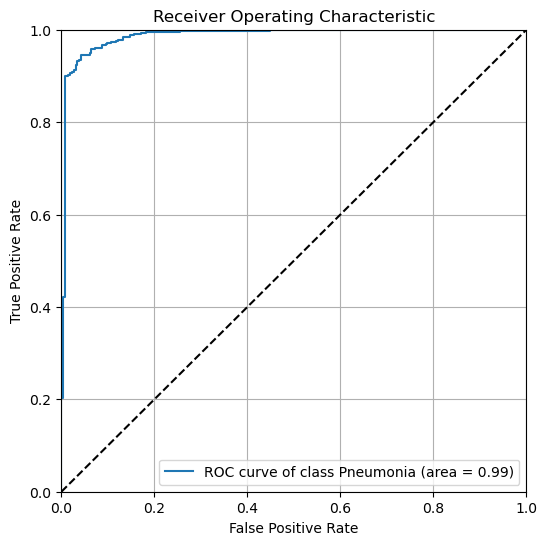

In [60]:
y_true = test_generator.labels
# Code for binary classification model

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

label = "Pneumonia"
#for i, label in enumerate(validation_generator.class_indices):
ax.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc))

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

Die ROC Kurve des Models zeigt hier sehr schön die gute Performance bei der True- und False Positiv Rate. Die ROC-AUC von 0.99 beweist, dass das Model in der Lage ist, positive Fälle zuverlässig zu identifizieren. Die hohe ROC-AUC liegt meiner Meinung auch an der Einfachheit der Klassifizierungsaufgabe. Es gibt nur 2 Klassen und die Erkennung, ob jemand an Pneumonia erkrankt ist oder nicht, ist relativ einfach.

In [63]:
#load log file and print history
log = pd.read_csv("models/CNN_Pneumonia_20230627-16h17min_training.log")
log.sort_values(by="val_loss", ascending=True)

,epoch,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
11,11,0.964895,0.091648,0.976552,0.975908,0.962415,0.094062,0.968603,0.979365
13,13,0.976353,0.070977,0.983196,0.984818,0.958998,0.105735,0.964063,0.979365
9,9,0.966602,0.092895,0.974729,0.980198,0.962415,0.108870,0.973059,0.974603
7,7,0.958313,0.119070,0.970385,0.973267,0.956720,0.115919,0.977419,0.961905
5,5,0.948074,0.130094,0.961652,0.968317,0.951025,0.116676,0.959311,0.973016
6,6,0.947830,0.136353,0.962246,0.967327,0.952164,0.118060,0.953704,0.980952
10,10,0.968552,0.083567,0.976042,0.981518,0.948747,0.125312,0.972536,0.955556
12,12,0.969039,0.082904,0.976996,0.981188,0.949886,0.128155,0.953560,0.977778
14,14,0.980010,0.058465,0.984550,0.988449,0.957859,0.131080,0.959690,0.982540
8,8,0.967089,0.095681,0.974746,0.980858,0.949886,0.135144,0.942598,0.990476


Ich habe einen Callback beim Training eingebaut der mir nur das beste Model speichert. Wie gut ein Model ist wird dabei vom val_loss abhängig gemacht. Dieses Model wurde nach Epoch 11 gespeichert.

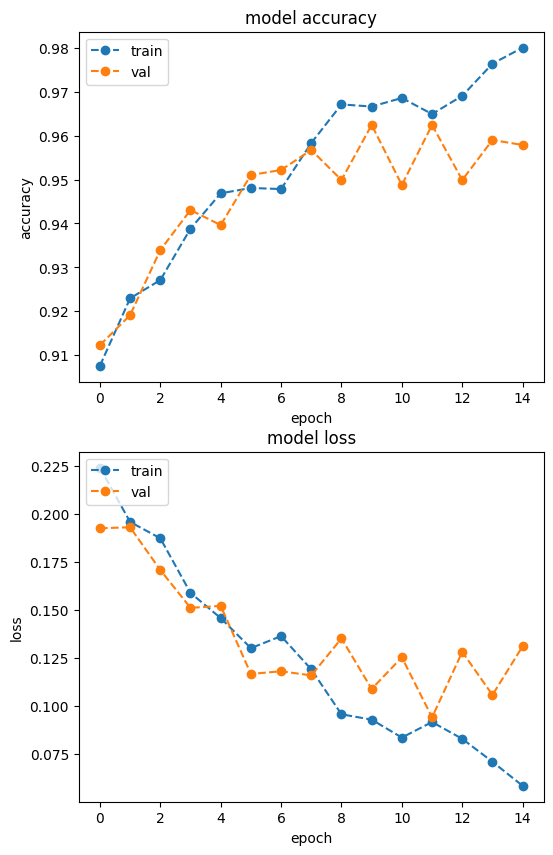

In [ ]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(log['accuracy'], "o--")
ax1.plot(log['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarize history for loss
ax2.plot(log['loss'], "o--")
ax2.plot(log['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

Aus Interesse habe ich hier einen Graphen geplottet der mir die Accuracy und den Loss über den Epochs darstellt. In diesem Plot erkennt man gut, dass der Val Loss stark anfängt zu schwanken ab Epoch 8.

#### CNN mit transfer learning (DenseNet121)

In [64]:
#load model and predict
model = keras.models.load_model("models/CNN_with_dense_net_Pneumonia_20230627-19h36min.hdf5")
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_4[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

Auch hier habe ich mein vortrainiertes Model geladen.

In [65]:
# Normalize images
image_generator_rgb = ImageDataGenerator(
    rescale=1.0/255 #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
)

# select the column with the labels
label_column = "pneumonia"

test_generator_rgb = image_generator_rgb.flow_from_dataframe(
        dataframe=test_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="rgb",
        shuffle = False) 

Found 876 validated image filenames.


Auch für dieses Model habe ich einen neuen Image Generator für die Testdaten initialisiert. Dieser ist auf RGB eingestellt, sodass wir zu den Trainingsdaten konsistent sind.

In [66]:
y_pred = model.predict(test_generator_rgb)

28/28 [==============================] - 70s 2s/step


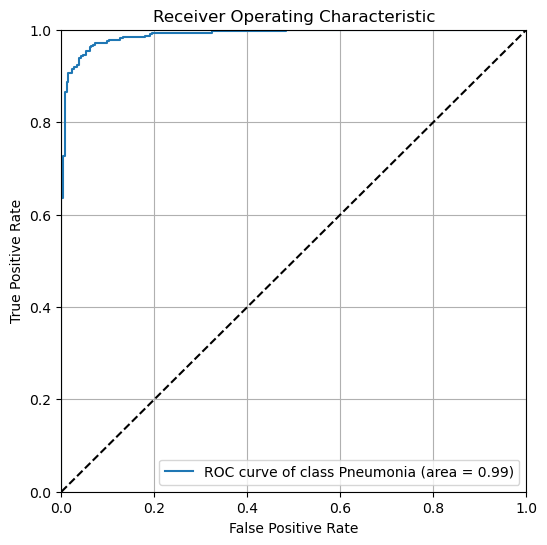

In [67]:
y_true = test_generator_rgb.labels
# Code for binary classification model

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

label = "Pneumonia"
#for i, label in enumerate(validation_generator.class_indices):
ax.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc))

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

Auch bei diesem Model liegt eine sehr gute AUC (0.99) vor. In der Performance liegen also sowohl das Model, welches mit transfer learning trainiert wurde, als auch das eigene CNN sehr nah beieinander.

In [68]:
#load log file and print history
log = pd.read_csv("models/CNN_with_dense_net_Pneumonia_20230627-19h36min_training.log")
log.sort_values(by="val_loss", ascending=True)

,epoch,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
10,10,0.964164,0.091802,0.972468,0.979208,0.964692,0.080541,0.970173,0.980952
11,11,0.967089,0.087561,0.977880,0.977558,0.965831,0.081572,0.970219,0.982540
14,14,0.970502,0.077410,0.976729,0.983498,0.968109,0.083068,0.980831,0.974603
12,12,0.967089,0.087988,0.974124,0.981518,0.970387,0.088415,0.982428,0.976190
4,4,0.956363,0.116742,0.969378,0.971617,0.970387,0.089816,0.973354,0.985714
3,3,0.951731,0.125307,0.963654,0.971287,0.963554,0.096473,0.973101,0.976190
2,2,0.955388,0.128560,0.966568,0.973267,0.964692,0.100556,0.976153,0.974603
7,7,0.961726,0.099650,0.972377,0.975908,0.960137,0.100699,0.985318,0.958730
1,1,0.945636,0.154027,0.962438,0.964026,0.960137,0.114063,0.959815,0.985714
8,8,0.963432,0.097454,0.973062,0.977558,0.953303,0.118512,0.942857,0.995238


Hier wurde das Model nach Epoch 10 gespeichert.

### Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

#### Which one achieves better results (and why): 
Beide Modelle weisen auf den Testdaten eine AUC von 0.99 auf und liegen damit in der Performance sehr nah zusammen. Beide Modelle liefern in dieser Klassifizerungsaufgabe auf den Testdaten also gleiche Ergebnisse. Das Model mit transfer learning kann seinen Vorteil, dass es auf einem sehr großen Datenset trainiert wurde, noch nicht ausspielen. Es liegen genug Trainingsdaten vor, sodass das eigene Model die Gewichtungen gut anpassen kann, ohne direkt zu overfitten. Der Grund warum beide Modelle sehr gut in dieser Aufgabe sind, liegt vermutlich daran, dass die Klassifizierungsaufgabe sehr einfach ist. Es gibt nur 2 Klassen und die Erkennung, ob jemand an Pneumonia erkrankt ist oder nicht, ist relativ einfach.

#### Which one trains faster (and why): 
Obwohl die trainierbaren Parameter bei dem Transfer Learning Model geringer ausfallen, braucht es mehr Zeit das Model zu trainieren und auf Daten vorherzusagen, als bei dem eigenen Model. Das liegt vermutlich daran, dass die Bilder das komplette Model durchlaufen müssen, welches bei dem Transfer Learning Ansatz deutlich mehr Layer beinhaltet. Die trainierbaren Parameter spielen also nicht die entscheidende Rolle bei der Trainingszeit, sondern auch die Anzahl der Layer und ihre Größe, selbst wenn weniger Gewichte trainiert werden müssen.

#### What would you prefer to use in an actual medical application: 
Ich würde das Model wählen, das mit dem Transfer Learning Ansatz trainiert wurde. Durch das große Datenset auf dem das DenseNet121 trainiert wurde und seinen komplexeren Aufbau, kann es wahrscheinlich besser mit Ausreißern oder Röntgenbilder in schlechterer Qualität umgehen. Außerdem lassen sich bei Bedarf noch weitere Layer trainieren, um das Model noch weiter zu optimieren. 


### 8. Train a CNN for a multi-class prediction (bacteria, virus, none)
- Adapt a CNN (e.g. pick one form 5. or 6.) and modify it to predict if a patient has a bacterial or a virus infection, or none of both using the `infection_type` column as label.
- This requires to also adapt the generators.

In [356]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator_rgb = ImageDataGenerator(
    rescale=1.0/255 #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
)

# select the column with the labels
label_column = ["bacteria", "none", "virus"]

# Define the data generators
train_generator_rgb = image_generator_rgb.flow_from_dataframe(
        dataframe=train_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32, 
        class_mode="raw", 
        color_mode="rgb" 
        )
val_generator_rgb = image_generator_rgb.flow_from_dataframe(
        dataframe=val_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="rgb",
        shuffle = False) 

Found 4102 validated image filenames.
Found 878 validated image filenames.


Dieses Mal wird der Image Generator mit den Klassen `bacteria`, `virus` und `none` erstellt. Später soll das Model eine dieser Klassen vorhersagen.

#### Überprüfung wie die Labels aussehen

In [357]:
batch = next(train_generator_rgb)

In [358]:
batch[1] #labels

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

Die Klassen liegen binär vor. Es trifft pro Bild immer eine der Klassen zu, nicht mehrere.

In [359]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(320,320,3))

Es wird ein neues Base Model erstellt. Wie auch in Schritt 5 werden die letzten Layer nicht übernommen.

In [360]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 326, 326, 3)  0          ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                       

In [361]:
from tensorflow.keras.layers import GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x) #reduziert den letzten layer drastisch auf einen Wert pro Block(1024)
x = Dense(64, activation="relu")(x)
output = Dense(len(label_column), activation="softmax")(x) #softmax weil wir ein multiclass Klassifizierungsproblem haben und eine der Klassen ausgewählt werden soll

model_with_dense_net = Model(inputs=base_model.input, outputs= output)
model_with_dense_net.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 326, 326, 3)  0          ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                           

 conv2_block6_1_relu (Activatio  (None, 80, 80, 128)  0          ['conv2_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block6_2_conv (Conv2D)   (None, 80, 80, 32)   36864       ['conv2_block6_1_relu[0][0]']    
                                                                                                  
 conv2_block6_concat (Concatena  (None, 80, 80, 256)  0          ['conv2_block5_concat[0][0]',    
 te)                                                              'conv2_block6_2_conv[0][0]']    
                                                                                                  
 pool2_bn (BatchNormalization)  (None, 80, 80, 256)  1024        ['conv2_block6_concat[0][0]']    
                                                                                                  
 pool2_rel

Die Model Architektur unterscheidet sich kaum zu dem Transfer Learning Model aus Schritt 5. Allerdings habe ich die Anzahl der Neuronen im Output Layer angepasst. Es gibt für jede Klasse ein Neuron, in diesem Fall 3. Außerdem habe ich mich entschieden die Softmax Aktivierungsfunktion für verwenden. Diese Funktion erzeugt eine Wahrscheinlichkeitsverteilung über alle Klassen und stellt sicher, dass die Summe der Wahrscheinlichkeiten aller Klassen 1 ergibt. Auf diese Weise stelle ich sicher, dass immer nur eine Klasse zutrifft. 

In [362]:
#wir wollen das net von keras nicht trainieren nur unseren letzten layer
for layer in base_model.layers:
    layer.trainable = False
    
model_with_dense_net.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 326, 326, 3)  0          ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                           

                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 40, 40, 32)   36864       ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_block4_concat (Concatena  (None, 40, 40, 256)  0          ['conv3_block3_concat[0][0]',    
 te)                                                              'conv3_block4_2_conv[0][0]']    
                                                                                                  
 conv3_block5_0_bn (BatchNormal  (None, 40, 40, 256)  1024       ['conv3_block4_concat[0][0]']    
 ization) 

Auch hier werden erst einmal nur die hinzugefügten Layer trainiert. Später werde ich das Model noch fein tunen und mehrere Layer trainieren.

In [59]:
classes = ["none", "bacteria", "virus"]

# Calculate class weights
class_weights = train_data[classes].sum(axis=0)
class_weights = class_weights.sum() / class_weights 

# Ensure class weights sum up to 1
class_weights = class_weights / class_weights.sum()
class_weights

none        0.389186
bacteria    0.209652
virus       0.401161
dtype: float64

Um den Bias in den Daten auszugleichen, habe ich die Gewichtungen für jede Klasse berechnet. Die Klassen `virus` und `none` werden höher gewichtet als `bacteria` (die überrepresentierte Klasse).

In [60]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def weighted_binary_crossentropy(class_weights):
    class_weights = tf.constant([class_weights[k] for k in sorted(class_weights.keys())], dtype=tf.float32)  # ensure class_weights is float32

    def _weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # ensure y_true is float32
        y_pred = tf.cast(y_pred, tf.float32)  # ensure y_pred is float32
        crossentropy = binary_crossentropy(y_true, y_pred)
        weight_vector = tf.reduce_sum(class_weights * y_true, axis=-1)
        weighted_loss = weight_vector * crossentropy
        return tf.reduce_mean(weighted_loss)

    return _weighted_binary_crossentropy

In [368]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model_with_dense_net.compile(optimizer='adam',
              loss=weighted_binary_crossentropy(class_weights),
              metrics=metrics)

Hier bleibt alles gleich zu Schritt 5.

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d-%Hh%Mmin")
filename = f"models/CNN_with_dense_net_InfectionType_{date}.hdf5"
csv_logger = CSVLogger(f'models/CNN_with_dense_net_InfectionType_{date}_training.log')
callbacks = [
    keras.callbacks.ModelCheckpoint(filename, save_best_only=True),
    csv_logger,
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15

model_with_dense_net.fit(train_generator_rgb,
          epochs=epochs,
          validation_data=val_generator_rgb,
          verbose=1,
          callbacks=callbacks)

Epoch 1/15
129/129 [==============================] - 475s 4s/step - loss: 0.1295 - accuracy: 0.7040 - precision: 0.7423 - recall: 0.6621 - val_loss: 0.1083 - val_accuracy: 0.7597 - val_precision: 0.7779 - val_recall: 0.7460
Epoch 2/15
129/129 [==============================] - 547s 4s/step - loss: 0.1037 - accuracy: 0.7718 - precision: 0.7839 - recall: 0.7552 - val_loss: 0.0964 - val_accuracy: 0.7768 - val_precision: 0.7913 - val_recall: 0.7642
Epoch 3/15
129/129 [==============================] - 563s 4s/step - loss: 0.0994 - accuracy: 0.7765 - precision: 0.7869 - recall: 0.7643 - val_loss: 0.0972 - val_accuracy: 0.7528 - val_precision: 0.7682 - val_recall: 0.7437
Epoch 4/15
129/129 [==============================] - 557s 4s/step - loss: 0.0954 - accuracy: 0.7816 - precision: 0.7920 - recall: 0.7723 - val_loss: 0.0905 - val_accuracy: 0.7802 - val_precision: 0.7865 - val_recall: 0.7677
Epoch 5/15
129/129 [==============================] - 535s 4s/step - loss: 0.0915 - accuracy: 0.7991

Um das Training nicht so zeitaufwändig zu gestalten, habe ich hier noch zusätzlich early stopping integriert. Sollte der Validation Loss 4 Epochs in Folge nicht mehr sinken, bricht das Training ab. Man könnte die Patience auch noch anheben, umso aus eventuell auftretenden lokalen Minima herauszukommen und noch einen besseren Val Loss zu finden. Bei nur 15 Epochs habe ich mich aber für eine Patience von 4 entschieden.

### 9. Evaluate the multi-class model
- Evaluate the multi-class prediction model, simliar to what you did in (7.). Again also include a ROC curve (now of course for all 3 possible labels).
- Is the performance comparable, better, worse than the pneumonia/no pneumonia case?
- Which label can be predicted with the highest precision?

In [380]:
#load model and predict
model = keras.models.load_model("models/CNN_with_dense_net_InfectionType_20230702-18h12min.hdf5", compile=False)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 326, 326, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [381]:
test_generator = image_generator.flow_from_dataframe(
        dataframe=test_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="rgb",
        shuffle = False) 

Found 876 validated image filenames.


Ich habe für die Evalierung einen neuen Image Generator für die Testdaten erstellt, der die neuen Labels beinhaltet.

In [382]:
y_true = test_generator.labels
y_true

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [383]:
y_pred = model.predict(test_generator)

28/28 [==============================] - 82s 3s/step


In [384]:
y_pred

array([[2.57128636e-06, 9.99987543e-01, 9.77972468e-06],
       [6.69908058e-03, 9.92496610e-01, 8.04220093e-04],
       [1.05826784e-05, 9.99960005e-01, 2.93680823e-05],
       ...,
       [7.85539269e-01, 8.40012357e-02, 1.30459532e-01],
       [7.50294626e-01, 2.79333517e-02, 2.21772000e-01],
       [8.94063234e-01, 5.98366372e-04, 1.05338454e-01]], dtype=float32)

In [385]:
y_pred_rounded = np.round(y_pred, 3)
y_pred_rounded

array([[0.   , 1.   , 0.   ],
       [0.007, 0.992, 0.001],
       [0.   , 1.   , 0.   ],
       ...,
       [0.786, 0.084, 0.13 ],
       [0.75 , 0.028, 0.222],
       [0.894, 0.001, 0.105]], dtype=float32)

Man erkennt hier sehr gut den Einfluss der Softmax Funktion. In der Summe ergibt die Wahrscheinlichkeitsverteilung der Klassen 1. Das Multi Labeling wird vermieden, sodass das Model sich auf eine Klasse festlegt.

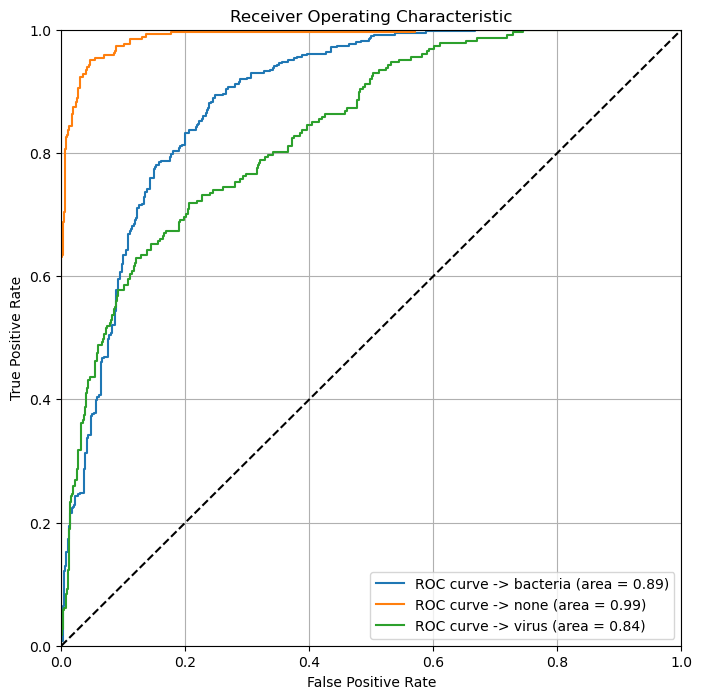

In [386]:
# Code for multi-class model
from sklearn.metrics import roc_curve, auc


# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = label_column

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

# Get class names
class_names = list(classes)

for i, label in enumerate(classes):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {label} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Evaluate the multi-class prediction model, simliar to what you did in (7.). Again also include a ROC curve (now of course for all 3 possible labels): 

Die ROC Curve zeigt hier sehr schön, dass das Model bei der Vorhersage ob jemand keine Infektion hat (`none`), immer noch eine sehr gute True- und False- Positive Rate aufweist. Die AUC liegt, wie auch schon bei der Vorhersage Pneumonia oder nicht, bei 0.99. Bei der Klassifizierung dieser Klasse ist das Model also gleich performant. Anders sieht es bei den Vorhersagen der Klassen `virus` und `bacteria` aus. Hier liegt die AUC für `virus` bei 0.84 und für `bacteria` bei 0.89. Dem Model fällt es also deutlich schwerer diese Klassen korrekt voherzusagen. In den nächsten Codeblöcken habe ich mir aus Interesse angeschaut, was das Model bei den Klassen `virus` und `bacteria` vorhersagt, wenn es denn falsch liegt. Die Konfusionsmatrix zeigt, dass es tatsächlich oft verwechselt, ob es eine virale oder bakterielle Infektion ist. Das Problem liegt also in der Unterscheidung dieser beiden Klassen. 
Der Performance Unterschied zwischen den Klassen `virus` und `bacteria` könnte sich auch auf den Bias in den Trainingsdaten zurückführen lassen. Dort war die Klasse `bacteria` überrepräsentiert. 

Ich gehe ebenfalls davon aus, dass diese Einordnung auch deutlich schwieriger ist, als nur vorherzusagen, ob jemand erkrankt ist oder nicht.

#### Is the performance comparable, better, worse than the pneumonia/no pneumonia case?

Allgemein weist dieses Model eine schlechtere Performance auf, als das Model das Pneumonia/kein Pneumonia vorhersagt. Allerdings ist die Fragestellung auch eine ganz andere, sodass ein direkter Vergleich unfair erscheint. Das Klassifikationsproblem ist hier deutlich komplexer als das vorherige und die Vorhersage, ob jemand keine Infektion hat (`none`), ist vergleichbar gut. 

#### Which label can be predicted with the highest precision? 
Das Label `none` kann mit der höchsten Precision vorhergesagt werden. Das Model hat hier eine ROC-AUC von 0.99 und liegt damit weit über den anderen zwei Klassen. Wie schon oben beschrieben vermute ich, dass es am einfachsten ist zu erkennnen, ob jemand eine Infektion hat oder nicht. Die Unterscheidung zwischen `virus` und `bacteria` ist deutlich schwieriger.

In [393]:
def plot_confusion_matrix(confusion_matrix):
    # Plot the confusion matrix using Seaborn's heatmap
    plt.figure(figsize=(6, 4), dpi=50)
    sb.heatmap(conf_matrix, annot=True, annot_kws={"size": 16},
               cmap="Purples",
               fmt="g")

    # Set labels and title
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title('Confusion Matrix', fontsize=20)

    # Show the plot
    plt.show()

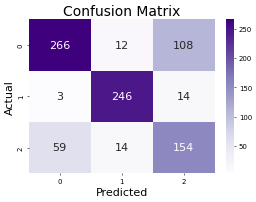

In [394]:
from sklearn import metrics

conf_matrix = metrics.confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(conf_matrix)

Wie oben beschrieben fällt dem Model die Unterscheidung schwer, ob es eine virale (2) oder bakterielle (0) Infektion ist. Die Klasse `none` (1) kann am besten vorhergesagt werden.

In [395]:
#load log file and print history
log = pd.read_csv("models/CNN_with_dense_net_InfectionType_20230702-18h12min_training.log")
log.sort_values(by="val_loss", ascending=True)

,epoch,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
9,9,0.809117,0.082259,0.815776,0.804242,0.792711,0.087134,0.797454,0.784738
8,8,0.807655,0.085381,0.813740,0.799854,0.785877,0.087301,0.799065,0.779043
7,7,0.805948,0.086626,0.811663,0.797416,0.791572,0.087439,0.799296,0.775626
13,13,0.815700,0.079303,0.820715,0.811312,0.781321,0.089153,0.790454,0.773349
6,6,0.805461,0.086643,0.814815,0.799122,0.788155,0.089418,0.799534,0.781321
12,12,0.820819,0.079371,0.826980,0.814481,0.760820,0.089742,0.766007,0.749431
3,3,0.781570,0.095418,0.792000,0.772306,0.780182,0.090531,0.786464,0.767654
10,10,0.821550,0.081290,0.826928,0.813018,0.768793,0.091465,0.778422,0.764237
11,11,0.809605,0.082685,0.815438,0.803510,0.804100,0.091504,0.806897,0.799544
5,5,0.784008,0.091655,0.792862,0.774500,0.777904,0.092389,0.789412,0.764237


Nach 14 Epochs hat das Early Stopping das Training beendet. Das Model nach Epoch 9 wurde gespeichert und weißt die niedrigsten Val Loss auf.

### 10. Possible improvements
Try two possible strategies to improve the results you got on 8. and 9.
- Data augmentation.
- Model fine tuning. This refers to the training of a large network with lower learning rate, but with more layers of the base model being set to `trainable`.

In [179]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator_rgb = ImageDataGenerator(
    rescale=1.0/255, #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
    rotation_range=10, #rotate the image randomly between -10 and 10 degrees
    horizontal_flip=True, #flip the image horizontally
    zoom_range=0.10, #zoom in or out on the image by up to 10%
)

# select the column with the labels
label_column = ["bacteria", "none", "virus"]


# Define the data generators
train_generator_rgb = image_generator_rgb.flow_from_dataframe(
        dataframe=train_data,
        x_col="image_path_and_filename", #x_col is the column with the filenames
        y_col=label_column,
        target_size=(320,320),
        batch_size=32, #how many images are loaded at once. 
        class_mode="raw", #raw because we have only one label column which is already encoded in 0 and 1
        color_mode="rgb" #grayscale because we have grayscale images
)
val_generator_rgb = image_generator_rgb.flow_from_dataframe(
        dataframe=val_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="rgb",
        shuffle = False) #im val dataset wollen wir nicht das er shuffelt sonst haben wir eine unterschiedliche Reihenfolge wenn wir auf val predicten

Found 4102 validated image filenames.
Found 878 validated image filenames.


Für das Model Finetuning habe ich hier Data Augmentation verwendet. Bei dem Bildgenerator wurde eingestellt, dass das Bild leicht gedreht wird. Außerdem wird es noch gezoomt sowie gespiegelt. Damit sollte mehr Variation in die Daten gebracht werden, sodass das Model robuster wird und nicht mehr so anfällig für Overfitting ist.

In [180]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(320,320,3))

In [181]:
from tensorflow.keras.layers import GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(64, activation="relu")(x)
output = Dense(len(label_column), activation="softmax")(x) 

model_with_dense_net = Model(inputs=base_model.input, outputs= output)
model_with_dense_net.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 326, 326, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                           

 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 80, 80, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 80, 80, 192)  0          ['conv2_block3_concat[0][0]',    
 te)                                                              'conv2_block4_2_conv[0][0]']    
                                                                                                  
 conv2_block5_0_bn (BatchNormal  (None, 80, 80, 192)  768        ['conv2_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

In [182]:
print(f"Our model has {len(model_with_dense_net.layers)} layers.")

Our model has 430 layers.


Das Model hat inklusive meiner letzten Layer insgesammt 430 Layer. Davon werde ich nun einige mehr trainieren, als beim letzten Mal.

In [183]:
for layer in model_with_dense_net.layers[:100]:
    layer.trainable = False
for layer in model_with_dense_net.layers[100:]:
    layer.trainable = True

Von den 430 Layer werden die ersten 100 Layer nicht trainiert. Der Rest wird trainiert.

In [184]:
from tensorflow.keras.optimizers import Adam

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Smaller learning rate for fine-tuning
model_with_dense_net.compile(optimizer=Adam(learning_rate=0.00001),
              #loss='binary_crossentropy',
              loss=weighted_binary_crossentropy(class_weights),
              metrics=metrics)

model_with_dense_net.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 326, 326, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                           

 conv2_block5_0_bn (BatchNormal  (None, 80, 80, 192)  768        ['conv2_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block5_0_relu (Activatio  (None, 80, 80, 192)  0          ['conv2_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block5_1_conv (Conv2D)   (None, 80, 80, 128)  24576       ['conv2_block5_0_relu[0][0]']    
                                                                                                  
 conv2_block5_1_bn (BatchNormal  (None, 80, 80, 128)  512        ['conv2_block5_1_conv[0][0]']    
 ization)                                                                                         
          

Es werden nun deutlich mehr Parameter trainiert als beim letzten Mal. Außerdem habe ich die Learning Rate auf 0.00001 herabgesetzt. Diese betrug vorher 0.001. Eine kleinere Lernrate bedeutet, dass das Modell kleinere Schritte in Richtung des optimalen Gewichts macht.


In [186]:
import datetime
from keras.callbacks import CSVLogger

date = datetime.datetime.now().strftime("%Y%m%d-%Hh%Mmin")
filename = f"models/CNN_with_dense_net_InfectionType_{date}_finetuning.hdf5"
csv_logger = CSVLogger(f'models/CNN_with_dense_net_InfectionType_{date}_finetuning_training.log')

In [187]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filename, save_best_only=True),
    csv_logger,
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50

model_with_dense_net.fit(train_generator_rgb,
          epochs=epochs,
          validation_data=val_generator_rgb,
          verbose=1,
          callbacks=callbacks)

Epoch 1/50
129/129 [==============================] - 1197s 9s/step - loss: 0.1506 - accuracy: 0.6602 - precision: 0.7098 - recall: 0.5700 - val_loss: 0.1260 - val_accuracy: 0.7426 - val_precision: 0.7788 - val_recall: 0.7016
Epoch 2/50
129/129 [==============================] - 1242s 10s/step - loss: 0.1092 - accuracy: 0.7691 - precision: 0.7831 - recall: 0.7455 - val_loss: 0.0996 - val_accuracy: 0.7927 - val_precision: 0.8033 - val_recall: 0.7722
Epoch 3/50
129/129 [==============================] - 1328s 10s/step - loss: 0.0989 - accuracy: 0.7930 - precision: 0.8032 - recall: 0.7772 - val_loss: 0.0919 - val_accuracy: 0.7973 - val_precision: 0.8042 - val_recall: 0.7904
Epoch 4/50
129/129 [==============================] - 1343s 10s/step - loss: 0.0942 - accuracy: 0.8023 - precision: 0.8116 - recall: 0.7906 - val_loss: 0.0870 - val_accuracy: 0.8144 - val_precision: 0.8189 - val_recall: 0.8087
Epoch 5/50
129/129 [==============================] - 1341s 10s/step - loss: 0.0869 - accurac

Für das fine tuning habe ich die Epochs, sowie das Early Stopping erhöht. Da jetzt eine kleinere Learning Rate verwendet wird, kann es sein das es etwas länger dauert aus lokalen Minima herauszukommen. 

In [188]:
#load model and predict
model = keras.models.load_model("models/CNN_with_dense_net_InfectionType_20230703-19h14min_finetuning.hdf5", compile=False)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 326, 326, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                           

In [189]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255 #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
)

# select the column with the labels
label_column = ["bacteria", "none", "virus"]

test_generator = image_generator.flow_from_dataframe(
        dataframe=test_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="rgb",
        shuffle = False) 

Found 876 validated image filenames.


Auch hier wurde für die Testdaten ein Image Generator erstellt. Dieser beinhaltet aber keine Data Augmentation.

In [190]:
y_true = test_generator.labels

In [191]:
y_pred = model.predict(test_generator)

28/28 [==============================] - 81s 3s/step


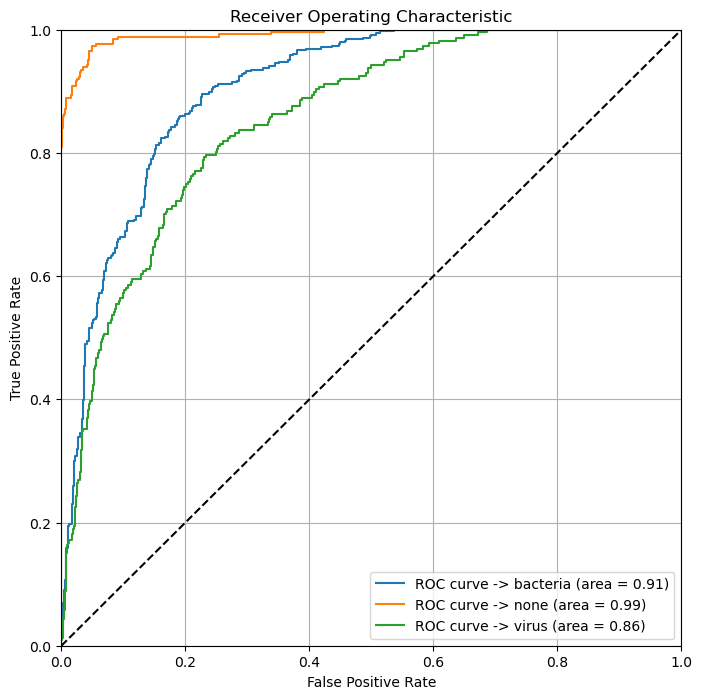

In [194]:
# Code for multi-class model
from sklearn.metrics import roc_curve, auc


# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = label_column

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

# Get class names
class_names = list(classes)

for i, label in enumerate(classes):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {label} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

Die ROC-AUC zeigt eine Verbesserung bei den Vorhersagen der Klassen `Virus` und `Bacteria`. Die AUC für `None` ist gleich geblieben.

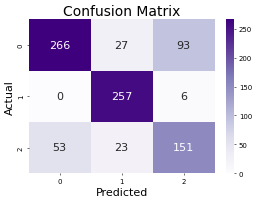

In [ ]:
from sklearn import metrics

conf_matrix = metrics.confusion_matrix(y_true.argmax(axis=1),y_pred.argmax(axis=1))
plot_confusion_matrix(conf_matrix)

Die Anzahl der Verwechslungen in den Vorhersagen zwischen `Bacteria` (0) und `Virus` (2) ist im Vergleich zu vor dem Feintuning gesunken. Bei der Einordnung, ob jemand keine Erkrankung hat (1) ist die Performance ebenfalls leicht gestiegen.

In [195]:
#load log file and print history
log = pd.read_csv("models/CNN_with_dense_net_InfectionType_20230703-19h14min_finetuning_training.log")
log.sort_values(by="val_loss", ascending=True)

,epoch,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
10,10,0.854949,0.066873,0.857529,0.851048,0.834852,0.077497,0.838303,0.832574
11,11,0.867138,0.064132,0.869843,0.863481,0.821185,0.079512,0.824541,0.818907
9,9,0.851048,0.070009,0.856087,0.846904,0.822323,0.079670,0.823394,0.817768
7,7,0.841297,0.074648,0.846344,0.835202,0.833713,0.079847,0.838524,0.828018
12,12,0.880302,0.058749,0.883075,0.876402,0.824601,0.079890,0.827231,0.823462
13,13,0.884203,0.054818,0.886820,0.882496,0.833713,0.080005,0.835240,0.831435
6,6,0.825939,0.080096,0.832052,0.817650,0.812073,0.081023,0.818391,0.810934
8,8,0.843247,0.072792,0.848619,0.839103,0.822323,0.082055,0.828736,0.821185
16,16,0.905412,0.045900,0.908021,0.902487,0.828018,0.082727,0.832761,0.828018
15,15,0.900780,0.049427,0.904026,0.897855,0.815490,0.082887,0.817241,0.809795


Das Training wurde nach 20 Epochs durch Early Stopping beendet. Der Val_Loss war nach dem 10 Epoch am Besten. Man sieht gut, dass das Model ab dem Zeitpunkt immer schelchter wurde, was wahrscheinlich auf Overfitting zurückzuführen ist. 

#### Do you see any promising effect of one or both of those strategies?
Das Feintuning hat dazu geführt, dass die Performance des Models gerade in den Vorhersagen der Klassen `virus` und `bacteria` besser geworden ist. Die AUC für `virus` liegt nun bei __0.86__ und für `bacteria` bei __0.91__. Vor dem Feintuning waren die Werte für `virus` __0.84__ und für `bacteria` __0.89__. Das Model kann also nun zuverlässiger beide Klassen vorhersagen. Das zeigt auch die Konfusionsmatrix. Die verringerte Learning Rate und erhöhte Menge an trainierbaren Parametern führen zwar zu einem längeren Training, ermöglichen es dem Model aber ein besseres Ergebnis zu finden und die Gewichtungen kleinschrittiger anzupassen. Die Data Augmentation der Bilder macht das Model robuster gegenüber schlechterem Input und ich gehe davon aus, dass das Model auch nicht mehr so schnell overfittet. Die verringerte Learning Rate trägt wahrscheinlich auch noch dazu bei.
Da ich beide Ansätze gleichzeitig angewendet habe, ist es natürlich schwer einem der Strategien den Erfolg zuzuschreiben. Ich denke jede der Strategien hatte seinen Vorteil. Durch die erhöhte Anzahl an trainierbaren Paramatern konnte das Model besser an den Anwendungsfall angepasst werden, die verringerte Learning Rate hat dazu beigetragen ein optimales globales Minima zu finden und die Data Augmentation hat das Model robuster gemacht und die Wahrscheinlichkeit auf Overfitting verringert.